# Plotting intersecting regulons

## Find intersecting DE regulons for each lineage and plot them below
- concept is to plot the top intersecting regulons between similar lineages of mouse and human. 
- Control:: Plot top 10 regulons per lineage within each species

    - Define only regulons which are regulated by homologous TFs in each species
    - Define (conserved) intersecting regulons: DE test for top 20 regulons per lineage in each species. 
    - Plot top regulons for each lineage in the same order and across each celltype. 
    - Plot also regulons that are not intersecting and thus species specific

In [1]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import scanpy as sc
from dask.diagnostics import ProgressBar
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell
import seaborn as sns
import matplotlib as plt

In [6]:
hu_lineages = {
'Erythroid':['HSPC_1','HSPC_2','MEMP','Early_Erythroid','Erythroid',],
'Macrophage':['HSPC_1','CMP','MOP','Promonocyte','Monocyte','Monocyte_Macrophage','Macrophage',],
'MK':['HSPC_1','HSPC_2','MEMP','MK']
}

In [7]:
# Grab intersecting homolog TFs between human/mouse for each lineage

# Ordering by diffusion pseudotime GAM modelling

# Human

In [8]:
adata_hu = sc.read('./data/hu_diff_regulon_aucell.h5ad')
adata_hu_raw = sc.read('./data/hu_diff_regulon.h5ad')

In [ ]:
for lineage in hu_lineages.keys():
    root = 'HSPC_1'
    adata_hu_tmp = adata_hu_raw[adata_hu_raw.obs['cell.labels'].isin(hu_lineages[lineage])]

    import harmonypy as hm
    adata_hu_tmp.uns['iroot'] = np.flatnonzero(adata_hu_tmp.obs['cell.labels'] == root)[0]
    #sc.pp.normalize_total(adata_hu_tmp , target_sum=1e4)
    #sc.pp.log1p(adata_hu_tmp )
    #sc.pp.highly_variable_genes(adata_hu_tmp, min_mean=0.0125, max_mean=3, min_disp=0.5)
    #sc.pp.scale(adata_hu_tmp , zero_center=True, max_value=None, copy=False, layer=None, obsm=None)
    sc.pp.pca(adata_hu_tmp, n_comps=50, use_highly_variable=False, svd_solver='arpack')
    theta = 5
    print("Commencing harmony")
    batch_var = 'species_donor'
    # Create hm subset
    adata_hm = adata_hu_tmp[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = [batch_var]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use,theta=theta)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
    adata_hu_tmp = adata_hm[:]
    del adata_hm
    sc.tl.diffmap(adata_hu_tmp , n_comps=50, neighbors_key='neighbors', random_state=0, copy=False)
    sc.tl.dpt(adata_hu_tmp , n_dcs=10, n_branchings=1, min_group_size=0.01, allow_kendall_tau_shift=True, neighbors_key='neighbors', copy=False)
    #sc.tl.draw_graph(adata_hu_tmp)

    # Save the data
    adata_hu_tmp.write('./data/' + lineage + '_hu_lineage_trial_dffimap.h5ad')
    sc.pl.diffmap(adata_hu_tmp, color=['cell.labels','dpt_pseudotime'],legend_loc='on data')
    #sc.pl.draw_graph(adata_hu_tmp, color=['cell.labels', 'dpt_pseudotime'], legend_loc='on data')

    orig_adata_hu_tmp = adata_hu_tmp[:]
    adata_hu_au_tmp = adata_hu[adata_hu.obs.index.isin(adata_hu_tmp.obs.index)]
    adata_hu_au_tmp.obs['dpt_pseudotime'] = adata_hu_tmp.obs['dpt_pseudotime']
    adata_hu_au_tmp.obs['stage'] = adata_hu_tmp.obs['stage']

    # Slice by intersection with mouse for speed
    homologne = pd.read_csv('./human_mouse_intersect_tfs.csv',index_col=0)
    adata_hu_au_tmp = adata_hu_au_tmp[:, list(homologne.iloc[:,0])]
    adata_hu_au_tmp

    #sc.pp.normalize_total(adata_hu_au_tmp,target_sum=10000)
    sc.pp.normalize_total(adata_hu_au_tmp , target_sum=1e4)
    sc.pp.log1p(adata_hu_au_tmp)

    met = adata_hu_au_tmp.obs
    met = met.sort_values('dpt_pseudotime', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
    met['ordering'] = range(0,len(met))
    adata_hu_au_tmp.obs['ordering'] = met['ordering']

    # Hypothesis can the trend of tf expression by explained by background mean expression at time?
    time = met['dpt_pseudotime']
    labels = met['cell.labels']
    data = adata_hu_au_tmp.X[adata_hu_au_tmp.obs['ordering']]
    data = pd.DataFrame(data)
    data.columns = adata_hu_au_tmp.var.index
    data.index = met.index
    # Mean trend
    data_means = data.mean(axis=1)

    #plt.scatter(time , data["HOXB6(+)"] , color='r')

    ## start of GAM module
    from pygam import PoissonGAM,LinearGAM, s, te
    data = adata_hu_au_tmp.X[adata_hu_au_tmp.obs['ordering']]
    data = pd.DataFrame(data)
    data.columns = adata_hu_au_tmp.var.index
    data.index = met.index
    X =data #data.iloc[:,0]
    y = time
    #gam = PoissonGAM(s(0, n_splines=200) ).fit(X, y)
    
    #gam_grid = LogisticGAM().gridsearch(np.array(X), y)
    gam_grid = LinearGAM().gridsearch(np.array(X), y)

    gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
    gam_out['positions'] = list(range(0,len(gam_out)))
    sig_gam = gam_out[gam_out['p_val']<0.05]


    #Save model
    data.to_csv('./gam_outs/' + lineage + '_hu_regulon_dat.csv')
    pd.DataFrame(y).to_csv('./gam_outs/' + lineage + '_hu_regulon_psd_time.csv')
    gam_out.to_csv('./gam_outs/' + lineage + '_hu_gam_outs.csv')
    sig_gam.to_csv('./gam_outs/' + lineage + '_hu_sig_gam.csv')

    import pickle 
    filename = './gam_outs/' + lineage + '_hu_gam.pkl'
    # save
    with open(filename, 'wb') as f:
        pickle.dump(gam_grid, f)

## Macrophage trajectory needs some categories to be merged and a lower PC count

In [78]:
hu_lineages = {
'Erythroid':['HSPC_1','HSPC_2','MEMP','Early_Erythroid','Erythroid',],
'Macrophage_1':['HSPC_1','CMP','MOP','Monocyte','Promonocyte','Monocyte','Monocyte_Macrophage','Macrophage','Microglia'],
'Macrophage':['HSPC_1','CMP','MOP','Monocyte','Promonocyte','Monocyte','Monocyte_Macrophage','Macrophage','Microglia'],
'MK':['HSPC_1','HSPC_2','MEMP','MK']
}

Trying to set attribute `.uns` of view, copying.


Commencing harmony


2021-12-09 14:20:35,094 - harmonypy - INFO - Iteration 1 of 10
2021-12-09 14:20:39,004 - harmonypy - INFO - Iteration 2 of 10
2021-12-09 14:20:42,992 - harmonypy - INFO - Iteration 3 of 10
2021-12-09 14:20:45,541 - harmonypy - INFO - Iteration 4 of 10
2021-12-09 14:20:48,127 - harmonypy - INFO - Iteration 5 of 10
2021-12-09 14:20:50,191 - harmonypy - INFO - Converged after 5 iterations


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell.labels' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell.labels_orig' as categorical


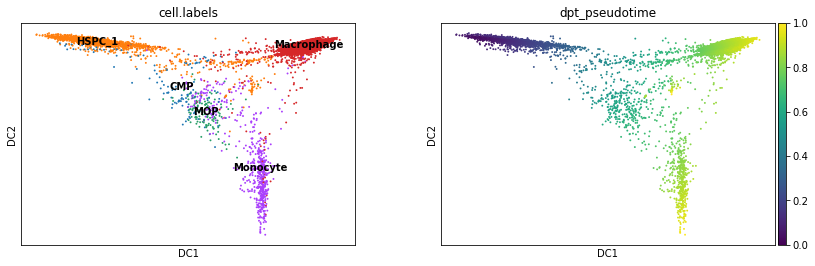

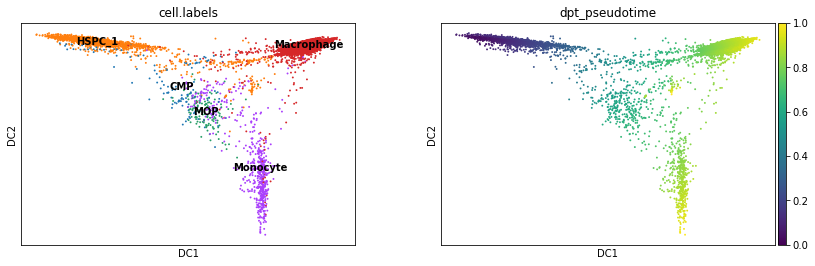

Trying to set attribute `.obs` of view, copying.


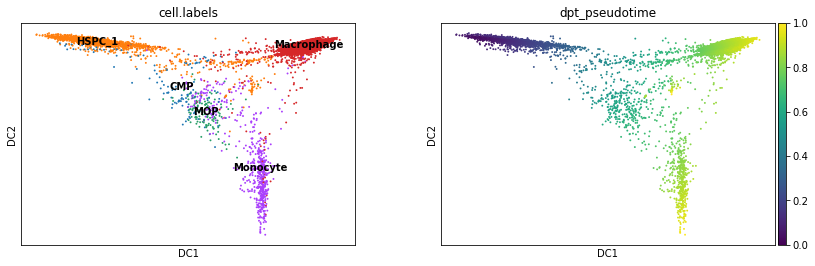

100% (11 of 11) |########################| Elapsed Time: 0:01:14 Time:  0:01:14


In [80]:
for lineage in ['Macrophage']:#hu_lineages.keys():
    root = 'HSPC_1'
    adata_hu_raw.obs['cell.labels_orig'] = adata_hu_raw.obs['cell.labels'][:]
    adata_hu_tmp = adata_hu_raw[adata_hu_raw.obs['cell.labels'].isin(hu_lineages['Macrophage_1'])]
    adata_hu_raw.obs['cell.labels'] = adata_hu_raw.obs['cell.labels'].astype(str)
    adata_hu_raw.obs.loc[adata_hu_raw.obs['cell.labels'].isin(['Monocyte','Monocyte_Macrophage','Macrophage']),'cell.labels'] = adata_hu_raw.obs.loc[adata_hu_raw.obs['cell.labels'].isin(['Monocyte','Monocyte_Macrophage','Macrophage']),'broad_cell.labels']
    adata_hu_raw.obs.loc[adata_hu_raw.obs['cell.labels_orig'].isin(['Promonocyte']),'cell.labels'] = adata_hu_raw.obs.loc[adata_hu_raw.obs['cell.labels_orig'].isin(['Promonocyte']),'cell.labels_orig'] # retain promono
    
    adata_hu_raw.obs['cell.labels'] =adata_hu_raw.obs['cell.labels'].str.replace('Microglia','Macrophage')
    
    import harmonypy as hm
    adata_hu_tmp.uns['iroot'] = np.flatnonzero(adata_hu_tmp.obs['cell.labels'] == root)[0]
    #sc.pp.normalize_total(adata_hu_tmp , target_sum=1e4)
    #sc.pp.log1p(adata_hu_tmp )
    #sc.pp.highly_variable_genes(adata_hu_tmp, min_mean=0.0125, max_mean=3, min_disp=0.5)
    #sc.pp.scale(adata_hu_tmp , zero_center=True, max_value=None, copy=False, layer=None, obsm=None)
    sc.pp.pca(adata_hu_tmp, n_comps=50, use_highly_variable=False, svd_solver='arpack')
    theta = 3
    print("Commencing harmony")
    batch_var = 'species_donor'
    # Create hm subset
    adata_hm = adata_hu_tmp[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = [batch_var]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use,theta=theta)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm, n_neighbors=5, n_pcs=50)
    adata_hu_tmp = adata_hm[:]
    del adata_hm
    sc.tl.diffmap(adata_hu_tmp , n_comps=50, neighbors_key='neighbors', random_state=0, copy=False)
    sc.tl.dpt(adata_hu_tmp , n_dcs=10, n_branchings=1, min_group_size=0.01, allow_kendall_tau_shift=True, neighbors_key='neighbors', copy=False)
    #sc.tl.draw_graph(adata_hu_t
    sc.pl.diffmap(adata_hu_tmp, color=['cell.labels','dpt_pseudotime'],legend_loc='on data')
    
    # Create a subset of the monocytes which have lower overall dp
#     mono_mean = np.mean(adata_hu_tmp.obs.loc[adata_hu_tmp.obs['cell.labels'].isin(['Monocyte']),'dpt_pseudotime'])
#     mono_std = np.std(adata_hu_tmp.obs.loc[adata_hu_tmp.obs['cell.labels'].isin(['Monocyte']),'dpt_pseudotime'])
#     mono_median = np.median(adata_hu_tmp.obs.loc[adata_hu_tmp.obs['cell.labels'].isin(['Monocyte']),'dpt_pseudotime'])
#     mono_cut = mono_mean #+ mono_std
#     mono_out = adata_hu_tmp.obs.index[(adata_hu_tmp.obs['cell.labels'].isin(['Monocyte'])) & (adata_hu_tmp.obs['dpt_pseudotime']>mono_cut )]
#     adata_hu_tmp = adata_hu_tmp[~adata_hu_tmp.obs.index.isin(mono_out)]
    sc.pl.diffmap(adata_hu_tmp, color=['cell.labels','dpt_pseudotime'],legend_loc='on data')

    orig_adata_hu_tmp = adata_hu_tmp[:]
    adata_hu_au_tmp = adata_hu[adata_hu.obs.index.isin(adata_hu_tmp.obs.index)]
    adata_hu_au_tmp.obs['dpt_pseudotime'] = adata_hu_tmp.obs['dpt_pseudotime']
    adata_hu_au_tmp.obs['stage'] = adata_hu_tmp.obs['stage']

    # Slice by intersection with mouse for speed
    #homologne = pd.read_csv('./human_mouse_intersect_tfs.csv',index_col=0)
    #adata_hu_au_tmp = adata_hu_au_tmp[:, list(homologne.iloc[:,0])]
    #adata_hu_au_tmp
    
        # Save the data
    adata_hu_tmp.write('./data/' + lineage + '_hu_lineage_trial_dffimap.h5ad')
    sc.pl.diffmap(adata_hu_tmp, color=['cell.labels','dpt_pseudotime'],legend_loc='on data')
    #sc.pl.draw_graph(adata_hu_tmp, color=['cell.labels', 'dpt_pseudotime'], legend_loc='on data')

    #sc.pp.normalize_total(adata_hu_au_tmp,target_sum=10000)
    sc.pp.normalize_total(adata_hu_au_tmp , target_sum=1e4)
    sc.pp.log1p(adata_hu_au_tmp)

    met = adata_hu_au_tmp.obs
    met = met.sort_values('dpt_pseudotime', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
    met['ordering'] = range(0,len(met))
    adata_hu_au_tmp.obs['ordering'] = met['ordering']

    # Hypothesis can the trend of tf expression by explained by background mean expression at time?
    time = met['dpt_pseudotime']
    labels = met['cell.labels']
    data = adata_hu_au_tmp.X[adata_hu_au_tmp.obs['ordering']]
    data = pd.DataFrame(data)
    data.columns = adata_hu_au_tmp.var.index
    data.index = met.index
    # Mean trend
    data_means = data.mean(axis=1)

    #plt.scatter(time , data["HOXB6(+)"] , color='r')

    ## start of GAM module
    from pygam import PoissonGAM,LinearGAM, s, te
    data = adata_hu_au_tmp.X[adata_hu_au_tmp.obs['ordering']]
    data = pd.DataFrame(data)
    data.columns = adata_hu_au_tmp.var.index
    data.index = met.index
    X =data #data.iloc[:,0]
    y = time
    #gam = PoissonGAM(s(0, n_splines=200) ).fit(X, y)
    
    #gam_grid = LogisticGAM().gridsearch(np.array(X), y)
    gam_grid = LinearGAM().gridsearch(np.array(X), y)

    gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
    gam_out['positions'] = list(range(0,len(gam_out)))
    sig_gam = gam_out[gam_out['p_val']<0.05]


    #Save model
    data.to_csv('./gam_outs/' + lineage + '_hu_regulon_dat.csv')
    pd.DataFrame(y).to_csv('./gam_outs/' + lineage + '_hu_regulon_psd_time.csv')
    gam_out.to_csv('./gam_outs/' + lineage + '_hu_gam_outs.csv')
    sig_gam.to_csv('./gam_outs/' + lineage + '_hu_sig_gam.csv')

    import pickle 
    filename = './gam_outs/' + lineage + '_hu_gam.pkl'
    # save
    with open(filename, 'wb') as f:
        pickle.dump(gam_grid, f)

## MK trajectory needs a lower PC count

In [81]:
hu_lineages = {
'Erythroid':['HSPC_1','HSPC_2','MEMP','Early_Erythroid','Erythroid',],
'Macrophage_1':['HSPC_1','CMP','MOP','Monocyte','Promonocyte','Monocyte','Monocyte_Macrophage','Macrophage','Microglia'],
'Macrophage':['HSPC_1','CMP','MOP','Monocyte','Promonocyte','Monocyte','Monocyte_Macrophage','Macrophage','Microglia'],
'MK':['HSPC_1','HSPC_2','MEMP','MK']
}

Trying to set attribute `.uns` of view, copying.


Commencing harmony


2021-12-09 15:13:54,092 - harmonypy - INFO - Iteration 1 of 10
2021-12-09 15:13:55,531 - harmonypy - INFO - Iteration 2 of 10
2021-12-09 15:13:56,884 - harmonypy - INFO - Iteration 3 of 10
2021-12-09 15:13:58,436 - harmonypy - INFO - Iteration 4 of 10
2021-12-09 15:13:59,942 - harmonypy - INFO - Iteration 5 of 10
2021-12-09 15:14:01,419 - harmonypy - INFO - Iteration 6 of 10
2021-12-09 15:14:02,692 - harmonypy - INFO - Iteration 7 of 10
2021-12-09 15:14:03,738 - harmonypy - INFO - Iteration 8 of 10
2021-12-09 15:14:04,913 - harmonypy - INFO - Iteration 9 of 10
2021-12-09 15:14:06,541 - harmonypy - INFO - Iteration 10 of 10
2021-12-09 15:14:08,084 - harmonypy - INFO - Stopped before convergence
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical ob

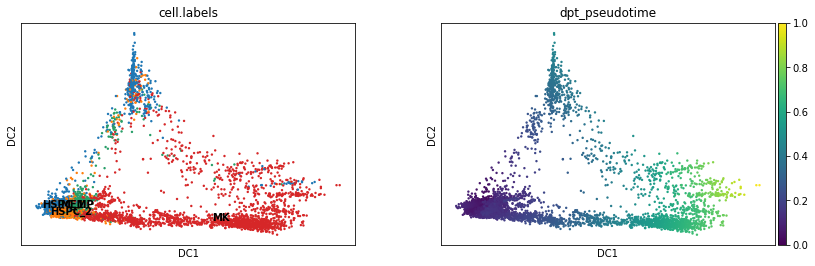

Trying to set attribute `.uns` of view, copying.


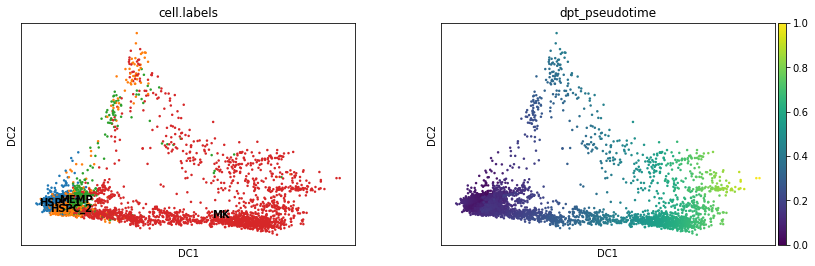

Trying to set attribute `.obs` of view, copying.


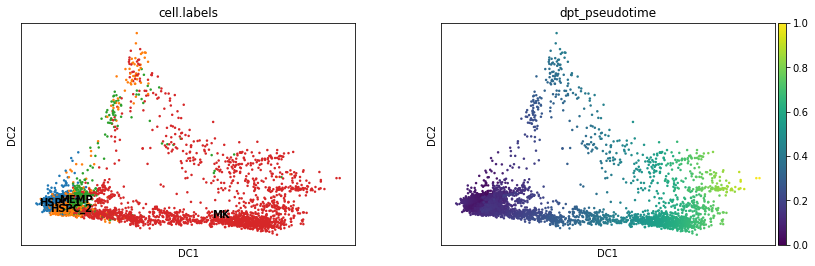

100% (11 of 11) |########################| Elapsed Time: 0:00:52 Time:  0:00:52


In [101]:
for lineage in ['MK']:#hu_lineages.keys():
    root = 'HSPC_1'
    adata_hu_raw.obs['cell.labels_orig'] = adata_hu_raw.obs['cell.labels'][:]
    adata_hu_tmp = adata_hu_raw[adata_hu_raw.obs['cell.labels'].isin(hu_lineages[lineage])]
    adata_hu_raw.obs['cell.labels'] = adata_hu_raw.obs['cell.labels'].astype(str)
    adata_hu_raw.obs.loc[adata_hu_raw.obs['cell.labels'].isin(['Monocyte','Monocyte_Macrophage','Macrophage']),'cell.labels'] = adata_hu_raw.obs.loc[adata_hu_raw.obs['cell.labels'].isin(['Monocyte','Monocyte_Macrophage','Macrophage']),'broad_cell.labels']
    adata_hu_raw.obs.loc[adata_hu_raw.obs['cell.labels_orig'].isin(['Promonocyte']),'cell.labels'] = adata_hu_raw.obs.loc[adata_hu_raw.obs['cell.labels_orig'].isin(['Promonocyte']),'cell.labels_orig'] # retain promono
    
    adata_hu_raw.obs['cell.labels'] =adata_hu_raw.obs['cell.labels'].str.replace('Microglia','Macrophage')
    
    import harmonypy as hm
    adata_hu_tmp.uns['iroot'] = np.flatnonzero(adata_hu_tmp.obs['cell.labels'] == root)[0]
    #sc.pp.normalize_total(adata_hu_tmp , target_sum=1e4)
    #sc.pp.log1p(adata_hu_tmp )
    #sc.pp.highly_variable_genes(adata_hu_tmp, min_mean=0.0125, max_mean=3, min_disp=0.5)
    #sc.pp.scale(adata_hu_tmp , zero_center=True, max_value=None, copy=False, layer=None, obsm=None)
    sc.pp.pca(adata_hu_tmp, n_comps=50, use_highly_variable=False, svd_solver='arpack')
    theta = 5
    print("Commencing harmony")
    batch_var = 'species_donor'
    # Create hm subset
    adata_hm = adata_hu_tmp[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = [batch_var]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use,theta=theta)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm, n_neighbors=5, n_pcs=50)
    adata_hu_tmp = adata_hm[:]
    del adata_hm
    sc.tl.diffmap(adata_hu_tmp , n_comps=5, neighbors_key='neighbors', random_state=0, copy=False)
    sc.tl.dpt(adata_hu_tmp , n_dcs=5, n_branchings=1, min_group_size=0.01, allow_kendall_tau_shift=True, neighbors_key='neighbors', copy=False)
    #sc.tl.draw_graph(adata_hu_t
    sc.pl.diffmap(adata_hu_tmp, color=['cell.labels','dpt_pseudotime'],legend_loc='on data')


    mono_mean = np.mean(adata_hu_tmp.obs.loc[adata_hu_tmp.obs['cell.labels'].isin(['HSPC_1']),'dpt_pseudotime'])
    mono_std = np.std(adata_hu_tmp.obs.loc[adata_hu_tmp.obs['cell.labels'].isin(['HSPC_1']),'dpt_pseudotime'])
    mono_median = np.median(adata_hu_tmp.obs.loc[adata_hu_tmp.obs['cell.labels'].isin(['HSPC_1']),'dpt_pseudotime'])
    mono_cut = mono_mean #+ mono_std
    mono_out = adata_hu_tmp.obs.index[(adata_hu_tmp.obs['cell.labels'].isin(['HSPC_1'])) & (adata_hu_tmp.obs['dpt_pseudotime']>mono_cut )]
    adata_hu_tmp = adata_hu_tmp[~adata_hu_tmp.obs.index.isin(mono_out)]
    
    # Create a subset of the monocytes which have lower overall dp
#     mono_mean = np.mean(adata_hu_tmp.obs.loc[adata_hu_tmp.obs['cell.labels'].isin(['Monocyte']),'dpt_pseudotime'])
#     mono_std = np.std(adata_hu_tmp.obs.loc[adata_hu_tmp.obs['cell.labels'].isin(['Monocyte']),'dpt_pseudotime'])
#     mono_median = np.median(adata_hu_tmp.obs.loc[adata_hu_tmp.obs['cell.labels'].isin(['Monocyte']),'dpt_pseudotime'])
#     mono_cut = mono_mean #+ mono_std
#     mono_out = adata_hu_tmp.obs.index[(adata_hu_tmp.obs['cell.labels'].isin(['Monocyte'])) & (adata_hu_tmp.obs['dpt_pseudotime']>mono_cut )]
#     adata_hu_tmp = adata_hu_tmp[~adata_hu_tmp.obs.index.isin(mono_out)]
    sc.pl.diffmap(adata_hu_tmp, color=['cell.labels','dpt_pseudotime'],legend_loc='on data')

    orig_adata_hu_tmp = adata_hu_tmp[:]
    adata_hu_au_tmp = adata_hu[adata_hu.obs.index.isin(adata_hu_tmp.obs.index)]
    adata_hu_au_tmp.obs['dpt_pseudotime'] = adata_hu_tmp.obs['dpt_pseudotime']
    adata_hu_au_tmp.obs['stage'] = adata_hu_tmp.obs['stage']

    # Slice by intersection with mouse for speed
    #homologne = pd.read_csv('./human_mouse_intersect_tfs.csv',index_col=0)
    #adata_hu_au_tmp = adata_hu_au_tmp[:, list(homologne.iloc[:,0])]
    #adata_hu_au_tmp
    
        # Save the data
    adata_hu_tmp.write('./data/' + lineage + '_hu_lineage_trial_dffimap.h5ad')
    sc.pl.diffmap(adata_hu_tmp, color=['cell.labels','dpt_pseudotime'],legend_loc='on data')
    #sc.pl.draw_graph(adata_hu_tmp, color=['cell.labels', 'dpt_pseudotime'], legend_loc='on data')

    #sc.pp.normalize_total(adata_hu_au_tmp,target_sum=10000)
    sc.pp.normalize_total(adata_hu_au_tmp , target_sum=1e4)
    sc.pp.log1p(adata_hu_au_tmp)

    met = adata_hu_au_tmp.obs
    met = met.sort_values('dpt_pseudotime', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
    met['ordering'] = range(0,len(met))
    adata_hu_au_tmp.obs['ordering'] = met['ordering']

    # Hypothesis can the trend of tf expression by explained by background mean expression at time?
    time = met['dpt_pseudotime']
    labels = met['cell.labels']
    data = adata_hu_au_tmp.X[adata_hu_au_tmp.obs['ordering']]
    data = pd.DataFrame(data)
    data.columns = adata_hu_au_tmp.var.index
    data.index = met.index
    # Mean trend
    data_means = data.mean(axis=1)

    #plt.scatter(time , data["HOXB6(+)"] , color='r')

    ## start of GAM module
    from pygam import PoissonGAM,LinearGAM, s, te
    data = adata_hu_au_tmp.X[adata_hu_au_tmp.obs['ordering']]
    data = pd.DataFrame(data)
    data.columns = adata_hu_au_tmp.var.index
    data.index = met.index
    X =data #data.iloc[:,0]
    y = time
    #gam = PoissonGAM(s(0, n_splines=200) ).fit(X, y)
    
    #gam_grid = LogisticGAM().gridsearch(np.array(X), y)
    gam_grid = LinearGAM().gridsearch(np.array(X), y)

    gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
    gam_out['positions'] = list(range(0,len(gam_out)))
    sig_gam = gam_out[gam_out['p_val']<0.05]


    #Save model
    data.to_csv('./gam_outs/' + lineage + '_hu_regulon_dat.csv')
    pd.DataFrame(y).to_csv('./gam_outs/' + lineage + '_hu_regulon_psd_time.csv')
    gam_out.to_csv('./gam_outs/' + lineage + '_hu_gam_outs.csv')
    sig_gam.to_csv('./gam_outs/' + lineage + '_hu_sig_gam.csv')

    import pickle 
    filename = './gam_outs/' + lineage + '_hu_gam.pkl'
    # save
    with open(filename, 'wb') as f:
        pickle.dump(gam_grid, f)

In [ ]:
# Remove some HSPCs which are seriously messing up the trajectory

Trying to set attribute `.uns` of view, copying.


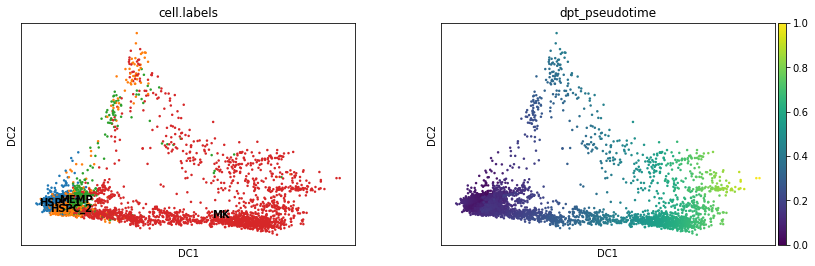

In [100]:
sc.pl.diffmap(adata_hu_tmp, color=['cell.labels','dpt_pseudotime'],legend_loc='on data')

In [84]:
gam_grid.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    193.9415
Link Function:                     IdentityLink Log Likelihood:                                -44435.6448
Number of Samples:                         5168 AIC:                                            89261.1726
                                                AICc:                                           89276.5373
                                                GCV:                                                0.0478
                                                Scale:                                              0.0446
                                                Pseudo R-Squared:                                    0.051
Feature Function                  Lam

<ipython-input-84-6453d77d0908>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_grid.summary()


# MS GAM modelling

In [102]:
adata_ms = sc.read('./data/ms_diff_regulon_au.h5ad')
adata_ms_raw = sc.read('./data/ms_diff_regulon.h5ad')

In [103]:
ms_lineages = {
'Macrophage':['HSPC_1_lineage_mouse_gastrulation','Macrophage_lineage_mouse_gastrulation'],
'MK':['HSPC_1_lineage_mouse_gastrulation','MK_lineage_mouse_gastrulation'],
 'Erythroid':['HSPC_1_lineage_mouse_gastrulation','Erythroid_lineage_mouse_gastrulation',],
}

In [ ]:
for lineage in ms_lineages.keys():
    
    root = 'HSPC_1_lineage_mouse_gastrulation'
    adata_ms_tmp = adata_ms_raw[adata_ms_raw.obs['predicted'].isin(ms_lineages[lineage])]

    import harmonypy as hm
    adata_ms_tmp.uns['iroot'] = np.flatnonzero(adata_ms_tmp.obs['predicted'] == root)[0]
    #sc.pp.normalize_total(adata_hu_tmp , target_sum=1e4)
    #sc.pp.log1p(adata_hu_tmp )
    #sc.pp.highly_variable_genes(adata_hu_tmp, min_mean=0.0125, max_mean=3, min_disp=0.5)
    #sc.pp.scale(adata_hu_tmp , zero_center=True, max_value=None, copy=False, layer=None, obsm=None)
    sc.pp.pca(adata_ms_tmp, n_comps=50, use_highly_variable=False, svd_solver='arpack')
    theta = 3
    print("Commencing harmony")
    batch_var = 'species_donor'
    # Create hm subset
    adata_hm = adata_ms_tmp[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = [batch_var]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use,theta=theta)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
    adata_ms_tmp = adata_hm[:]
    del adata_hm
    sc.tl.diffmap(adata_ms_tmp , n_comps=50, neighbors_key='neighbors', random_state=0, copy=False)
    sc.tl.dpt(adata_ms_tmp , n_dcs=10, n_branchings=1, min_group_size=0.01, allow_kendall_tau_shift=True, neighbors_key='neighbors', copy=False)
    #sc.tl.draw_graph(adata_ms_tmp)

    sc.pl.diffmap(adata_ms_tmp, color=['predicted','dpt_pseudotime'],legend_loc='on data')

    adata_ms_tmp.write('./data/' + lineage + '_ms_lineage_dffimap.h5ad')

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import statsmodels.api as sm

    orig_adata_ms_tmp = adata_ms_tmp[:]
    #adata_ms_tmp = orig_adata_ms_tmp[:]adata_ms 
    adata_ms_au_tmp = adata_ms[adata_ms.obs.index.isin(adata_ms_tmp.obs.index)]
    adata_ms_au_tmp.obs[['dpt_pseudotime']] = adata_ms_tmp.obs[['dpt_pseudotime']]
    #adata_ms_au_tmp.obs['diff_map_kmeans'] = adata_ms_tmp.obs['diff_map_kmeans']
    adata_ms_au_tmp.obs['stage'] = adata_ms_tmp.obs['stage']
    
    mono_mean = np.mean(adata_ms_au_tmp.obs.loc[adata_ms_au_tmp.obs['predicted'].isin(['HSPC_1_lineage_mouse_gastrulation']),'dpt_pseudotime'])
    mono_std = np.std(adata_ms_au_tmp.obs.loc[adata_ms_au_tmp.obs['predicted'].isin(['HSPC_1_lineage_mouse_gastrulation']),'dpt_pseudotime'])
    mono_median = np.median(adata_ms_au_tmp.obs.loc[adata_ms_au_tmp.obs['predicted'].isin(['HSPC_1_lineage_mouse_gastrulation']),'dpt_pseudotime'])
    mono_cut = mono_mean + mono_std
    mono_out = adata_ms_au_tmp.obs.index[(adata_ms_au_tmp.obs['predicted'].isin(['HSPC_1_lineage_mouse_gastrulation'])) & (adata_ms_au_tmp.obs['dpt_pseudotime']>mono_cut )]
    adata_ms_au_tmp = adata_ms_au_tmp[~adata_ms_au_tmp.obs.index.isin(mono_out)]
    
    
    #sc.pp.normalize_total(adata_ms_au_tmp,target_sum=10000)
    sc.pp.normalize_total(adata_ms_au_tmp , target_sum=1e4)
    sc.pp.log1p(adata_ms_au_tmp)

    met = adata_ms_au_tmp.obs
    met = met.sort_values('dpt_pseudotime', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
    met['ordering'] = range(0,len(met))
    adata_ms_au_tmp.obs['ordering'] = met['ordering']                   

    # Hypothesis can the trend of tf expression by explained by background mean expression at time?
    time = met['dpt_pseudotime']
    labels = met['cell.labels']
    data = adata_ms_au_tmp.X[adata_ms_au_tmp.obs['ordering']]
    data = pd.DataFrame(data)
    data.columns = adata_ms_au_tmp.var.index
    data.index = met.index
    # Mean trend
    data_means = data.mean(axis=1)                   


    homolog_map = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/mouse_gastrulation_data/mouse_data_var_built_261121_raw.csv')
    homolog_map['mouse_human_regulon_homolog'] = homolog_map['mouse_human_homologs'].astype(str) + "(+)"
    homolog_map = dict(zip((homolog_map['HGNC'].astype(str) + "(+)"),homolog_map['mouse_human_homologs'].astype(str) + "(+)" ))

    #adata_ms.var[adata_ms.var.index.isin(list(adata_ms_raw.var.index.values + "(+)"))]
    adata_ms_au_tmp.var['homolog_map'] = adata_ms_au_tmp.var.index.values
    adata_ms_au_tmp.var['homolog_map'] = adata_ms_au_tmp.var['homolog_map'].astype(str)
    adata_ms_au_tmp.var['homolog_map'] = adata_ms_au_tmp.var['homolog_map'].map(homolog_map)
    len(adata_ms_au_tmp.var['homolog_map'].unique())

    from pygam import PoissonGAM,LinearGAM,LogisticGAM, s, te
    data = adata_ms_au_tmp.X[adata_ms_au_tmp.obs['ordering']]
    data = pd.DataFrame(data)
    data.columns = adata_ms_au_tmp.var['homolog_map']
    data.index = met.index
    
    # Slice by intersection with mouse for speed
    homologs = pd.read_csv('./human_mouse_intersect_tfs.csv',index_col=0)
    
    data = data[data.columns[data.columns.isin(list(homologs.iloc[:,0]))]]
    X =data #data.iloc[:,0]
    y = time
    #gam = PoissonGAM(s(0, n_splines=200) ).fit(X, y)                   

    #gam_grid = LogisticGAM().gridsearch(np.array(X), y)
    gam_grid = LinearGAM().gridsearch(np.array(X), y)                   

    gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
    sig_gam = gam_out[gam_out['p_val']<0.07]                   

    #Save model
    data.to_csv('./gam_outs/' + lineage + '_ms_regulon_dat.csv')
    pd.DataFrame(y).to_csv('./gam_outs/' + lineage + '_ms_regulon_psd_time.csv')
    gam_out.to_csv('./gam_outs/' + lineage + '_ms_gam_outs.csv')
    sig_gam.to_csv('./gam_outs/' + lineage + '_ms_sig_gam.csv')

    import pickle 
    filename = './gam_outs/' + lineage + '_ms_gam.pkl'
        # save
    with open(filename, 'wb') as f:
        pickle.dump(gam_grid, f)

# MS Mac lineage needs some work

Trying to set attribute `.uns` of view, copying.


Commencing harmony


2021-12-09 15:55:28,177 - harmonypy - INFO - Iteration 1 of 10
2021-12-09 15:55:28,885 - harmonypy - INFO - Iteration 2 of 10
2021-12-09 15:55:29,430 - harmonypy - INFO - Iteration 3 of 10
2021-12-09 15:55:29,720 - harmonypy - INFO - Iteration 4 of 10
2021-12-09 15:55:30,098 - harmonypy - INFO - Iteration 5 of 10
2021-12-09 15:55:30,325 - harmonypy - INFO - Iteration 6 of 10
2021-12-09 15:55:30,540 - harmonypy - INFO - Iteration 7 of 10
2021-12-09 15:55:30,908 - harmonypy - INFO - Iteration 8 of 10
2021-12-09 15:55:31,142 - harmonypy - INFO - Iteration 9 of 10
2021-12-09 15:55:31,517 - harmonypy - INFO - Iteration 10 of 10
2021-12-09 15:55:31,921 - harmonypy - INFO - Stopped before convergence


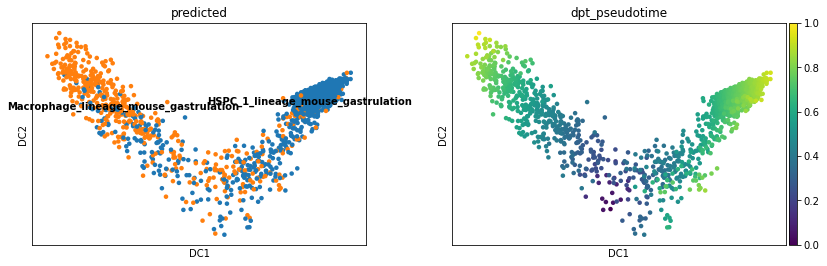

Trying to set attribute `.obs` of view, copying.


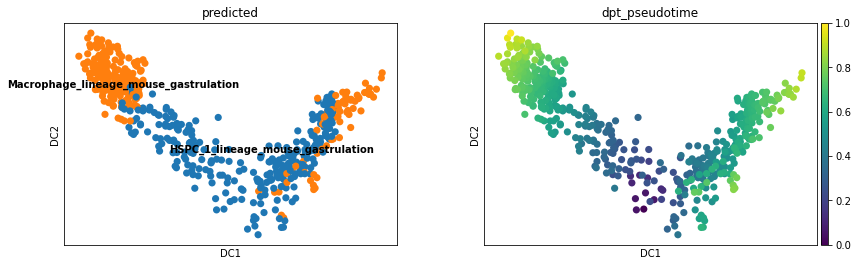

100% (11 of 11) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


In [113]:
for lineage in['Macrophage']:
    
    root = 'HSPC_1_lineage_mouse_gastrulation'
    adata_ms_tmp = adata_ms_raw[adata_ms_raw.obs['predicted'].isin(ms_lineages[lineage])]

    import harmonypy as hm
    adata_ms_tmp.uns['iroot'] = np.flatnonzero(adata_ms_tmp.obs['predicted'] == root)[0]
    #sc.pp.normalize_total(adata_hu_tmp , target_sum=1e4)
    #sc.pp.log1p(adata_hu_tmp )
    #sc.pp.highly_variable_genes(adata_hu_tmp, min_mean=0.0125, max_mean=3, min_disp=0.5)
    #sc.pp.scale(adata_hu_tmp , zero_center=True, max_value=None, copy=False, layer=None, obsm=None)
    sc.pp.pca(adata_ms_tmp, n_comps=50, use_highly_variable=False, svd_solver='arpack')
    theta = 3
    print("Commencing harmony")
    batch_var = 'species_donor'
    # Create hm subset
    adata_hm = adata_ms_tmp[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = [batch_var]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use,theta=theta)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
    adata_ms_tmp = adata_hm[:]
    del adata_hm
    sc.tl.diffmap(adata_ms_tmp , n_comps=50, neighbors_key='neighbors', random_state=0, copy=False)
    sc.tl.dpt(adata_ms_tmp , n_dcs=10, n_branchings=1, min_group_size=0.01, allow_kendall_tau_shift=True, neighbors_key='neighbors', copy=False)
    #sc.tl.draw_graph(adata_ms_tmp)

    sc.pl.diffmap(adata_ms_tmp, color=['predicted','dpt_pseudotime'],legend_loc='on data')

    adata_ms_tmp.write('./data/' + lineage + '_ms_lineage_dffimap.h5ad')

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import statsmodels.api as sm

    orig_adata_ms_tmp = adata_ms_tmp[:]
    #adata_ms_tmp = orig_adata_ms_tmp[:]adata_ms 
    adata_ms_au_tmp = adata_ms[adata_ms.obs.index.isin(adata_ms_tmp.obs.index)]
    adata_ms_au_tmp.obs[['dpt_pseudotime']] = adata_ms_tmp.obs[['dpt_pseudotime']]
    #adata_ms_au_tmp.obs['diff_map_kmeans'] = adata_ms_tmp.obs['diff_map_kmeans']
    adata_ms_au_tmp.obs['stage'] = adata_ms_tmp.obs['stage']
    
    mono_mean = np.mean(adata_ms_tmp.obs.loc[adata_ms_tmp.obs['predicted'].isin(['HSPC_1_lineage_mouse_gastrulation']),'dpt_pseudotime'])
    mono_std = np.std(adata_ms_tmp.obs.loc[adata_ms_tmp.obs['predicted'].isin(['HSPC_1_lineage_mouse_gastrulation']),'dpt_pseudotime'])
    mono_median = np.median(adata_ms_tmp.obs.loc[adata_ms_tmp.obs['predicted'].isin(['HSPC_1_lineage_mouse_gastrulation']),'dpt_pseudotime'])
    mono_cut = mono_mean #+ mono_std
    mono_out = adata_ms_tmp.obs.index[(adata_ms_tmp.obs['predicted'].isin(['HSPC_1_lineage_mouse_gastrulation'])) & (adata_ms_tmp.obs['dpt_pseudotime']>mono_cut )]
    adata_ms_tmp = adata_ms_tmp[~adata_ms_tmp.obs.index.isin(mono_out)]
    
    
    mono_mean = np.mean(adata_ms_tmp.obs.loc[adata_ms_tmp.obs['predicted'].isin(['Macrophage_lineage_mouse_gastrulation']),'dpt_pseudotime'])
    mono_std = np.std(adata_ms_tmp.obs.loc[adata_ms_tmp.obs['predicted'].isin(['Macrophage_lineage_mouse_gastrulation']),'dpt_pseudotime'])
    mono_median = np.median(adata_ms_tmp.obs.loc[adata_ms_tmp.obs['predicted'].isin(['Macrophage_lineage_mouse_gastrulation']),'dpt_pseudotime'])
    mono_cut = mono_mean #+ mono_std
    mono_out = adata_ms_tmp.obs.index[(adata_ms_tmp.obs['predicted'].isin(['Macrophage_lineage_mouse_gastrulation'])) & (adata_ms_tmp.obs['dpt_pseudotime']<mono_cut )]
    adata_ms_tmp = adata_ms_tmp[~adata_ms_tmp.obs.index.isin(mono_out)]
    
    
    sc.pl.diffmap(adata_ms_tmp, color=['predicted','dpt_pseudotime'],legend_loc='on data')
    adata_ms_tmp.write('./data/' + lineage + '_ms_lineage_dffimap.h5ad')
    
    #sc.pp.normalize_total(adata_ms_au_tmp,target_sum=10000)
    sc.pp.normalize_total(adata_ms_au_tmp , target_sum=1e4)
    sc.pp.log1p(adata_ms_au_tmp)

    met = adata_ms_au_tmp.obs
    met = met.sort_values('dpt_pseudotime', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
    met['ordering'] = range(0,len(met))
    adata_ms_au_tmp.obs['ordering'] = met['ordering']                   

    # Hypothesis can the trend of tf expression by explained by background mean expression at time?
    time = met['dpt_pseudotime']
    labels = met['cell.labels']
    data = adata_ms_au_tmp.X[adata_ms_au_tmp.obs['ordering']]
    data = pd.DataFrame(data)
    data.columns = adata_ms_au_tmp.var.index
    data.index = met.index
    # Mean trend
    data_means = data.mean(axis=1)                   


    homolog_map = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/mouse_gastrulation_data/mouse_data_var_built_261121_raw.csv')
    homolog_map['mouse_human_regulon_homolog'] = homolog_map['mouse_human_homologs'].astype(str) + "(+)"
    homolog_map = dict(zip((homolog_map['HGNC'].astype(str) + "(+)"),homolog_map['mouse_human_homologs'].astype(str) + "(+)" ))

    #adata_ms.var[adata_ms.var.index.isin(list(adata_ms_raw.var.index.values + "(+)"))]
    adata_ms_au_tmp.var['homolog_map'] = adata_ms_au_tmp.var.index.values
    adata_ms_au_tmp.var['homolog_map'] = adata_ms_au_tmp.var['homolog_map'].astype(str)
    adata_ms_au_tmp.var['homolog_map'] = adata_ms_au_tmp.var['homolog_map'].map(homolog_map)
    len(adata_ms_au_tmp.var['homolog_map'].unique())

    from pygam import PoissonGAM,LinearGAM,LogisticGAM, s, te
    data = adata_ms_au_tmp.X[adata_ms_au_tmp.obs['ordering']]
    data = pd.DataFrame(data)
    data.columns = adata_ms_au_tmp.var['homolog_map']
    data.index = met.index
    
    # Slice by intersection with mouse for speed
    homologs = pd.read_csv('./human_mouse_intersect_tfs.csv',index_col=0)
    
    data = data[data.columns[data.columns.isin(list(homologs.iloc[:,0]))]]
    X =data #data.iloc[:,0]
    y = time
    #gam = PoissonGAM(s(0, n_splines=200) ).fit(X, y)                   

    #gam_grid = LogisticGAM().gridsearch(np.array(X), y)
    gam_grid = LinearGAM().gridsearch(np.array(X), y)                   

    gam_out = pd.DataFrame(list(gam_grid.statistics_['p_values'])[:-1],index = data.columns.values,columns = ['p_val'])
    sig_gam = gam_out[gam_out['p_val']<0.07]                   

    #Save model
    data.to_csv('./gam_outs/' + lineage + '_ms_regulon_dat.csv')
    pd.DataFrame(y).to_csv('./gam_outs/' + lineage + '_ms_regulon_psd_time.csv')
    gam_out.to_csv('./gam_outs/' + lineage + '_ms_gam_outs.csv')
    sig_gam.to_csv('./gam_outs/' + lineage + '_ms_sig_gam.csv')

    import pickle 
    filename = './gam_outs/' + lineage + '_ms_gam.pkl'
        # save
    with open(filename, 'wb') as f:
        pickle.dump(gam_grid, f)

In [117]:
gam_grid.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     109.805
Link Function:                     IdentityLink Log Likelihood:                                -16777.4242
Number of Samples:                         1453 AIC:                                            33776.4584
                                                AICc:                                           33794.9323
                                                GCV:                                                0.0381
                                                Scale:                                              0.0329
                                                Pseudo R-Squared:                                   0.0955
Feature Function                  Lam

<ipython-input-117-6453d77d0908>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_grid.summary()
